In [14]:
import os
import cv2
import numpy as np
import SimpleITK as sitk

Stack 2D images into a volume

In [50]:
def padImages(image, target_shape):
    image_hgt, image_wdh = image.shape[:2]
    target_hgt, target_wdh = target_shape

    pad_top = (target_hgt - image_hgt) //2
    pad_bottom = target_hgt - image_hgt - pad_top
    pad_left = (target_wdh - image_wdh) //2
    pad_right = target_wdh - image_wdh - pad_left

    padded_image = np.pad(image, ((pad_top, pad_bottom),(pad_left, pad_right),(0,0)))
    return padded_image

In [51]:
def stackImages(input_dir):
    count = 0
    images = []
    shapes = []
    volume = []

    # sort list of .jpg/.jpeg files
    jpg_files = sorted([
        img for img in os.listdir(input_dir)
        if img.lower().endswith(('.jpg', '.jpeg'))
    ])
    
    for filename in jpg_files:
        #print(f"Processing image: {filename}")
        image_path = os.path.join(input_dir, filename)
        # read image in cv2, use color to preserve H&E
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            
        # convert image to numpy array and stacks into a volume
        images.append(image)
        shapes.append(image.shape)
        count += 1
        #print(f"Total image processed: {count}")

    max_height = max(size[0] for size in shapes)
    max_width = max(size[1] for size in shapes)
    target_shape = (max_height, max_width)

    for img in images:
        img = np.asarray(img, dtype=np.uint8)
        padded_img = padImages(img, target_shape)
        volume.append(padded_img)
        
    # convert to numpy array with shape = (num_slices, height, width)
    stack_array = np.stack(volume, axis=0)
    print(f"Volume shape: {stack_array.shape}")
    return stack_array

In [52]:
def saveVolume(stack_array, volume_name, output_dir):
    output_path = os.path.join(output_dir, volume_name)
    #stack_array = np.transpose(stack_array, (1,2,3,0))
    volume = sitk.GetImageFromArray(stack_array)
    sitk.WriteImage(volume, output_path)
    print(f"Saved volume to: {output_path}")

In [53]:
# paths and directories
input_path = r"C:\Users\Ally\BMIF2025\MBI\CISC 881\881 group project\SampleData\P20483_patient_1"
output_path = r"C:\Users\Ally\BMIF2025\MBI\CISC 881\881 group project\SampleData\image-to-volume"

# execute code
histo_volume = stackImages(input_path)
saveVolume(histo_volume, "patient1_volume.nrrd", output_path)

Volume shape: (50, 2278, 3264, 3)
Saved volume to: C:\Users\Ally\BMIF2025\MBI\CISC 881\881 group project\SampleData\image-to-volume\patient1_volume.nrrd


In [ ]:
count = 0
for filename in os.listdir(input_dir):
    if filename.startswith("._"):
        continue
    if filename.endswith(".tif") or filename.endswith(".tiff"):
        input_path = os.path.join(input_dir, filename)
        resized_output_path = os.path.join(resized_output_dir, f"{os.path.splitext(filename)[0]}_resized.tif")
        print(f"Processing file: {filename}")
        if os.path.exists(resized_output_path):
            print(f"Skipping {filename}, already resized")
            count += 1
            print(f"Total files processed: {count}")
            continue
        try:
            resize_image_to_target_size(input_path, resized_output_path, target_size_kb)
            count += 1
            print(f"Total files processed: {count}")
        except Exception as e:
            print(f"Error processing {filename}: {e}")

In [3]:
def resize_image_to_target_size(input_path, output_path, target_size_kb):
    '''
    reszie the image to target_size_kb
    :param input_path: file path of input image
    :param output_path: where to save the resized image
    :param target_size_kb: to load in cellprofiler
    :return: image with target size
    '''
    # load image
    image = cv2.imread(input_path)

    # check if the image was loaded successfully
    if image is None:
        raise ValueError(f"Failed to load image from {input_path}. Please check the file path or format.")

    file_size_kb = os.path.getsize(input_path) / 1024  # initial file size in KB

    # if already under the target size, save it directly
    if file_size_kb <= target_size_kb:
        print(f"No resizing needed for {input_path}, file size is already under {target_size_kb} KB.")
        imwrite(output_path, image)
        return image

    # scale factor
    scale_factor = 0.95

    # iterate to resize until file size is under the target size
    while file_size_kb > target_size_kb:
        # calculate new dimensions
        new_width = int(image.shape[1] * scale_factor)
        new_height = int(image.shape[0] * scale_factor)
        # resize the image
        resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
        # save temporarily to check file size
        temp_output_path = "temp_resized_image.png"
        cv2.imwrite(temp_output_path, resized_image)
        file_size_kb = os.path.getsize(temp_output_path) / 1024
        # reduce scale factor if still above limit
        scale_factor *= 0.95

    # load resized image back and save
    resized_image = cv2.imread(temp_output_path)
    os.remove(temp_output_path)  # clean up temporary file
    plt.imwrite(output_path, resized_image)  # save
    print(f"Resized image saved as {output_path}")
    return resized_image


In [5]:
def convert_to_multichannel(input_path, output_path):
    '''
    extract the hematoxylin and eosin stain form images to create a multichannel image
    :param input_path: path of input image
    :param output_path: path of output image
    :return: multichannel image with h&e channel
    '''
    # load images
    resized_image = cv2.imread(input_path)

    # convert to HED and separate channels
    image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)  # convert to RGB
    image_hed = rgb2hed(image_rgb)  # Convert RGB to HED


    null = np.zeros_like(image_hed[:, :, 0]) #https://scikit-image.org/docs/0.25.x/auto_examples/color_exposure/plot_ihc_color_separation.html
    fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True) 
    ax = axes.ravel()

    
    ihc_h = hed2rgb(np.stack((image_hed[:, :, 0], null, null), axis=-1))
    ax[1].imshow(ihc_h)
    ax[1].set_title("Hematoxylin")
    print("test2")

    ihc_e = hed2rgb(np.stack((null, image_hed[:, :, 1], null), axis=-1))
    ax[2].imshow(ihc_e)
    ax[2].set_title("Eosin")
    print("test")


    ihc_d = hed2rgb(np.stack((null, null, image_hed[:, :, 2]), axis=-1))
    ax[3].imshow(ihc_d)
    ax[3].set_title("DAB")
    print("test3")


    # normalize H&E channels to [0, 1] range
    hematoxylin = (image_hed[:, :, 0] - image_hed[:, :, 0].min()) / (
                image_hed[:, :, 0].max() - image_hed[:, :, 0].min())
    eosin = (image_hed[:, :, 1] - image_hed[:, :, 1].min()) / (image_hed[:, :, 1].max() - image_hed[:, :, 1].min())


    # create an empty channel
    empty_channel = np.zeros_like(hematoxylin)
    # combine channels
    multichannel_image = np.stack((hematoxylin, eosin, empty_channel), axis=-1)
    print(f"Multichannel image saved as {output_path}")
    return multichannel_image

    # save the final multichannel image
    imwrite(output_path, multichannel_image)


#https://github.com/EricaLiang09ukk/IBD_Severity_Prediction_project/blob/main/ibd%20process%20image%20to%20multichannel%20again2.ipynb

test2
test
test3
Multichannel image saved as C:\Users\laava\OneDrive\Documents


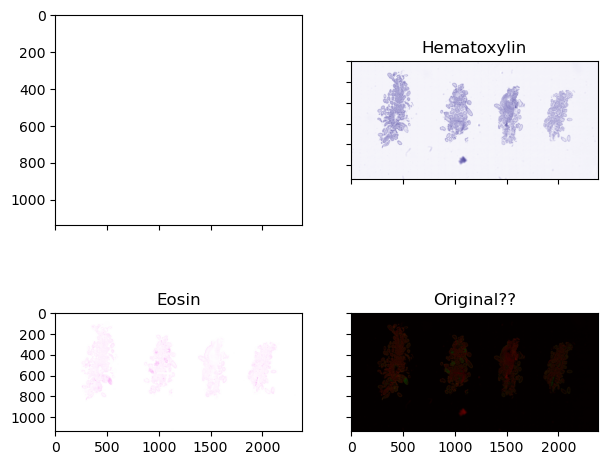

In [7]:
def main():
    target_size_kb = 34000
    #print(os.getcwd())
    #resized_image = resize_image_to_target_size("C:\\Users\\laava\\OneDrive\\Documents\\13_E_TI_F.tif", "C:\\Users\\laava\\OneDrive\\Documents", target_size_kb)
    multichannel_image = convert_to_multichannel("C:\\Users\\laava\\OneDrive\\Documents\\55514.jpg", "C:\\Users\\laava\\OneDrive\\Documents")
    plt.imshow(multichannel_image, cmap = 'Blues')
    plt.title("Original??")
    #print('hi')
    #plt.imshow(multichannel_image, cmap = 'Greens')


if __name__ == '__main__':
    main()